# Example to read map and spectra fits files from MADCUBA

MADCUBA exports a history file with the same name of the fits file ended with `_hist.csv`.

With the `MadcubaMap` and `SpectraContainer` classes we can open these fits files alongside thei history tables.

We start by importing the necessary libraries

In [1]:
from astropy.nddata import CCDData
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from pathlib import Path

from madcubapy.io import MadcubaMap
from madcubapy.io import SpectraContainer

Set Path of example files

In [2]:
data_folder = Path("../data")

# MadcubaMap

We can read the fits file with the MadcubaMap.read() method:

In [3]:
# Create the MadcubaMap object
madcuba_map = MadcubaMap.read(data_folder/"IRAS16293_SO_2-1_moment0_madcuba.fits")

FILNAM0 Import File                                                              [astropy.io.fits.card]
SPECMOD Import File                                                              [astropy.io.fits.card]
SPWNAM0 Import File                                                              [astropy.io.fits.card]
FILNAM0 Import File                                                              [astropy.io.fits.card]
SPECMOD Import File                                                              [astropy.io.fits.card]
SPWNAM0 Import File                                                              [astropy.io.fits.card]
keyword looks very much like CUNITia but isn't. [astropy.wcs.wcs]


The MadcubaMap class resembles the `CCDData` class from astropy with `data`, `header`, `wcs`, and `unit` attributes, with the addition of a `hist` attribute, the history table.

In [4]:
madcuba_map.hist

Index,FITS,Macro,Type,FROM_ROW,TO_ROW,Roi_Range,User,Date
int64,str1,str325,str2,int64,int64,int64,str5,str23
1,C,//ORIGIN=/home/david/Documents/MasterAstro/TFM/Data/Cubes/Band_3_12m-TM2/MAD_CUB_member.uid___A001_X133d_X320d.IRAS_16293-2422_sci.spw29.cube.I.pbcor.fits,I,--,--,--,--,--
2,C,"//INFO: Import CASA FITS FILE, ESTIMATED_SIGMA=0.005020903444186465",P,--,--,--,david,2022-10-14T14:39:05.876
3,C,"run(""Import CASA FITS FILE"",""select='/home/david/Documents/MasterAstro/TFM/Data/Band_3_12m-TM2-medium/2018.1.01496.S/science_goal.uid___A001_X133d_X3209/group.uid___A001_X133d_X320a/member.uid___A001_X133d_X320d/product//member.uid___A001_X133d_X320d.IRAS_16293-2422_sci.spw29.cube.I.pbcor.fits' changehead='Vrad$2.5$km/s'"");",P,--,--,--,david,2022-10-14T14:39:05.876
4,C,"run(""Open Virtual Cube"",""select='/home/david/Documents/MasterAstro/TFM/Data/Cubes/Band_3_12m-TM2/MAD_CUB_member.uid___A001_X133d_X320d.IRAS_16293-2422_sci.spw29.cube.I.pbcor.fits' "");",P,--,--,--,david,2023-05-02T13:12:32.467
5,C,//ORIGIN=CUBE MAD_CUB_member.uid___A001_X133d_X320d.IRAS_16293-2422_sci.spw29.cube.I.pbcor.fits,I,--,--,--,--,--
6,C,"//selectWindow(""CUBE MAD_CUB_member.uid___A001_X133d_X320d.IRAS_16293-2422_sci.spw29.cube.I.pbcor.fits"");",I,--,--,--,--,--
7,C,"run(""INTEGRATED INTENSITY PLUGIN"",""ranges=500.0$5500.0$# axisunit=m s-1 interpolate=0"");",P,--,--,--,david,2023-05-02T13:12:34.442
8,C,"run(""Save Cube"",""select='/home/david/Documents/MasterAstro/TFM/Data/Cubes/Band_3_12m-TM2/integrated_SO_TM2_range05_center3.fits'"");",P,--,--,--,david,2023-05-02T13:12:47.239
9,C,//PYTHON: Open cube: '../data/IRAS16293_SO_2-1_moment0_madcuba.fits',Py,--,--,--,david,2024-12-13T10:10:20.237


As a failsafe, a CCDDdata object is also present inside the MadcubaMap in the `ccddata` attribute.

In [5]:
madcuba_map.ccddata

CCDData([[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]], dtype='>f4', unit='Jy m / (beam s)')

We can plot the data array of the fits file from the `data` attribute. Keep in mind that usually we need to do some slicing to get rid of the spectral and polarization axes if present.

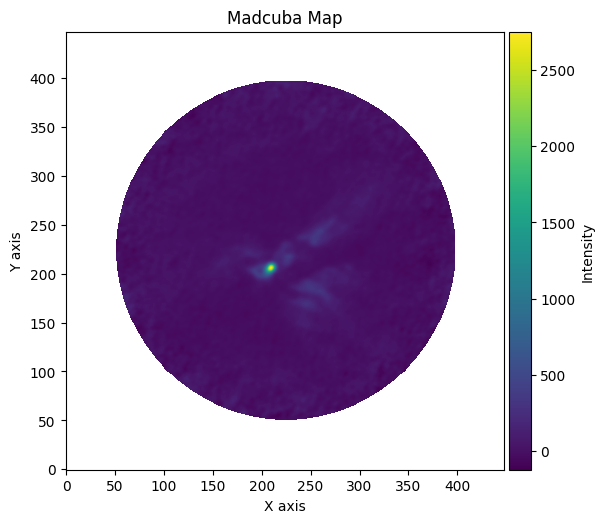

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
map_data = madcuba_map.data[0, 0, :, :]  # apply slicing
img = ax.imshow(map_data, cmap='viridis', origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax, label='Intensity')

ax.set_title('Madcuba Map')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

plt.show()

We can get a lot of information from the header and wcs parameters like the units for the axes, but that will be shown in a future example using utility functions.

## Fix units

Some programs export the BUNIT fits card incorrectly with more than one slash and astropy has problems parsing units in those strings. With this method the user can try to fix this problem and correctly parse the units.

For example, CARTA exports units like this. When we read a CARTA map, astropy gives us a warning:

In [7]:
carta_map = MadcubaMap.read(data_folder/"IRAS16293_SO2c_moment0_carta.fits")

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


The warning is telling us that we have a string with multiple slashes: 'Jy/beam.km/s', and the 'km' are placed on the denominator:

In [8]:
carta_map.unit

Unit("Jy / (beam km s)")

We can run the `fix_units` method of MadcubaMap to fix this.

In [9]:
carta_map.fix_units()
carta_map.unit

Unit("Jy km / (beam s)")

It is important to note that the ccddata object inside MadcubaMap also gets the correct units when they are fixed.

In [10]:
carta_map.ccddata.unit

Unit("Jy km / (beam s)")

Even though a CARTA exported map does not have a _hist.csv file, it is encouraged to read it as a MadcubaMap, even when the user wants to work with a CCDData object. That's why we have the failsafe CCDData object in the `MadcubaMap.ccddata` atribute.

In [11]:
carta_ccddata = carta_map.ccddata
carta_ccddata
# We can work with carta_ccddata just as if it was directly read with the
# CCDData.read() method from astropy.

CCDData([[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]], dtype='>f4', unit='Jy km / (beam s)')

# SpectraContainer

Spectra are exported from MADCUBA in a single fits file containing a bintable with each one of the spectra inside. This fits file is then packaged alongside the history file inside a `.spec` archive. 

With the SpectraContainer class we can open MADCUBA's `.spec` files.

In [12]:
# Create the SpectraContainer object
spectra_container = SpectraContainer.read(data_folder/"IRAS16293_position_8_TM2_spectra.spec")

The spectra are stores in teh `bintable` attribute, which is an Astropy table contaning the data and header information for every spectra.

In [13]:
# Show the first two spectra inside as an example
spectra_container.bintable[0:2]

PROJID,OBSERVER,VERSION,CRPIX1,CRPIX2,SCAN,OBS-NUM,DATE-OBS,TIME-OBS,LST,DATE,EXPOSURE,OBJECT,AZIMUTH,ELEVATIO,HISTORY,ORIGIN,CTYPE3,CRPIX3,CRVAL3,CDELT3,CTYPE1,CRVAL1,CDELT1,CTYPE2,CRVAL2,CDELT2,EQUINOX,RADESYS,RESTFRQ,IMAGFREQ,SPECRES,MOLECULE,TRANSITION,VELDEF,VELREF,ALTRPIX,ALTRVAL,ZSOURCE,STOKES,CHANNELS,DATA,WEIGTHS,WAVE,TELESCOP,BMAJ,BMIN,BPA,FRONTEND,BACKEND,TSYS,TSYSIMAGE,OBSMODE,QUALITY,BUNIT,APEREFF,BEAMEFF,ETAFFS,ANTGAIN,GAINIMAG,RESTWAV,HIST-OLD,TEMPSCAL,XAXIS
,,,,,,,,s,s,,s,,deg,deg,,,,,,,,deg,deg,,deg,deg,,,Hz,Hz,,Hz,,,,,m / s,m / s,,,Jy,,m or Hz,,deg,deg,deg,,,K,K,,,,,,,K / Jy,,m,,,Hz
bytes32,bytes16,bytes24,int32,int32,int32,int32,bytes24,float64,float64,bytes24,float32,bytes32,float32,float32,bytes32,bytes24,bytes8,float64,float64,float64,bytes8,float64,float64,bytes8,float64,float64,bytes8,bytes8,float64,float64,float64,bytes16,bytes16,bytes8,int32,float64,float64,float64,bytes2,int32,object,object,object,bytes8,float32,float32,float32,bytes16,bytes16,float32,float32,bytes32,int32,bytes32,float32,float32,float32,float32,float32,float64,bytes32,bytes16,object
MASSA,rivilla,1,226,232,1,1,2018-12-16T13:42:49.7280,1665751050553.0,1000.0,2023-02-17T15:00:39.849Z,1.0,IRAS_16293-2422,180.0,90.0,history file name,MADCUBA,FREQ-LSR,1.0,93782290089.0,122068.8545532,RA---GLS,248.09417993127968,0.0,DEC--GLS,-24.475203611464742,0.0,2000.0,ICRS,93900000000.0,0.0,122068.8545532,Unknown,Unknown,VRAD-LSR,257,958.8763535915687,2500.0,8.339171921162217e-06,I,1918,[-0.00553309 -0.00566683 -0.00572642 ... -0.00119151 -0.00168416\n 0.0022412 ],[60835.836],[-1.],ALMA,-0.0005619182,-0.0005619182,0.0,PLOT MAD_CUB_mem,ber.uid___A001_X,100.0,100.0,MADCUBA,1,Jy,1.0,1.0,1.0,33.838852,0.0,0.0,0.0,TMB,[9.37822901e+10 9.37824122e+10 9.37825342e+10 ... 9.40160519e+10\n 9.40161740e+10 9.40162961e+10] Hz
MASSA,rivilla,1,226,232,1,1,2018-12-16T13:42:49.7280,1665751097826.0,1000.0,2023-02-17T15:00:39.449Z,1.0,IRAS_16293-2422,180.0,90.0,history file name,MADCUBA,FREQ-LSR,1.0,108880112783.0,122069.8044281,RA---GLS,248.09417993127968,0.0,DEC--GLS,-24.475203611464742,0.0,2000.0,ICRS,108998000000.0,0.0,122069.8044281,Unknown,Unknown,VRAD-LSR,257,959.2899888046014,2500.0,8.339171921162217e-06,I,1918,[-0.00065054 -0.00024617 -0.00393423 ... 0.0009739 -0.0042386\n 0.00021092],[37884.938],[-1.],ALMA,-0.00053032895,-0.00053032895,0.0,PLOT MAD_CUB_mem,ber.uid___A001_X,100.0,100.0,MADCUBA,1,Jy,1.0,1.0,1.0,28.194561,0.0,0.0,0.0,TMB,[1.08880113e+11 1.08880235e+11 1.08880357e+11 ... 1.09113876e+11\n 1.09113999e+11 1.09114121e+11] Hz


The spectrum data is contained in the `DATA` and `XAXIS` columns alongside their units if correctly parsed from the header.

We can quickly plot a spectrum by accesing these values

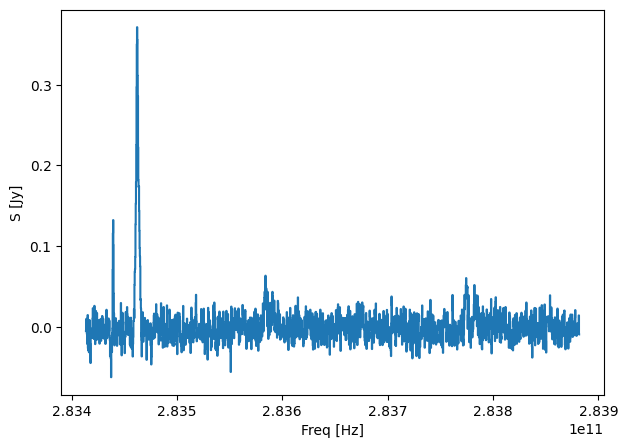

In [14]:
# select which spectrum to plot
index = 6

fig, ax = plt.subplots(1, 1, figsize=(7,5))

x = spectra_container.bintable[index]['XAXIS']
x_unit = spectra_container.bintable[index].table['XAXIS'].unit
y = spectra_container.bintable[index]['DATA']
y_unit = spectra_container.bintable[index].table['DATA'].unit

ax.plot(x, y, drawstyle='steps-mid')

ax.set_xlabel(f"Freq [{x_unit}]")
ax.set_ylabel(f"S [{y_unit}]")

plt.show()